<a href="https://colab.research.google.com/github/AsmaaIbrahiim/Face-Mask-Detection/blob/main/Face_Mask_Detection%7C_Transfer_learning_Models%7C_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

University of Science and Technology, Zewail City <br>
Communications and Information Engineering Program <br>
CIE 555 - Deep Learning and Neural Networks <br>
Course Project - **Face Mask Detection**

# **Imports**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
# =========================================== #
import keras.applications
from keras.models import Model
from keras.layers import Dense, Flatten,Dropout
import tensorflow as tf
#============================================== #
import numpy as np
from sklearn.metrics import classification_report
import os

# **Dataset Import**

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1UXAbqllbeh14XslYxAuTOfd3hsvbmp0G'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

#Get random images for testing
#fild_id = '1S2GHYiYFsquDhh1xxLTj_3RtkuXaIvNA'
#downloaded = drive.CreateFile({'id': file_id})
#downloaded.GetContentFile('random_images.zip')


In [ ]:
!mkdir /content/dataset
!unzip -q /content/archive.zip -d /content/dataset 
#!unzip -q /content/random_images.zip -d /content/random_test_images 

# **Loading data into generators + Helper Functions**

In [ ]:
# General Parameters
train_dir='/content/dataset/Face Mask Dataset/Train'
val_dir='/content/dataset/Face Mask Dataset/Validation'
test_dir='/content/dataset/Face Mask Dataset/Test'
random_test_dir = '/content/random_test_images'
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 500

In [ ]:
def get_generators(preprocessing_object = tf.keras.applications.vgg19.preprocess_input):
  #preprocessing_function = preprocessing_object,
  train_generator=ImageDataGenerator(
                                    preprocessing_function = preprocessing_object,
                                    rescale=1/255,
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  val_generator=ImageDataGenerator( 
                                    preprocessing_function = preprocessing_object,
                                    rescale=1/255,
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  test_generator= ImageDataGenerator(
                                    preprocessing_function = preprocessing_object)

  ### Generators; train, val and test
  train_data_generator=train_generator.flow_from_directory(train_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')

  val_data_generator=val_generator.flow_from_directory(val_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')
  test_data_generator=test_generator.flow_from_directory(test_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = 992,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')
  return train_data_generator, val_data_generator, test_data_generator

In [ ]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Categorical Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
def load_img_function(img_path, show=True):

    img = load_img(img_path, target_size=(HEIGHT, WIDTH))
    img_tensor = img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255                                      

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return np.vstack([img_tensor])

In [ ]:
# Generators
train_data_generator, val_data_generator, test_data_generator = get_generators(tf.keras.applications.vgg16.preprocess_input)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
images, labels = next(train_data_generator)

print(images.shape)
print(labels.shape)

(500, 128, 128, 3)
(500, 2)


# **Dataset Visualization**

In [ ]:
classes = ['masked','non_masked'] #The same arrangment as the dataset files!

***Note:***The shown images are after having the preprocessing (Data augmentation) applied! So, it would be somehow weird!

In [ ]:
#For visulaization purposes ONLY!
origianal_train_generator=ImageDataGenerator(rescale=1/255)
origianal_train_data_generator=origianal_train_generator.flow_from_directory(train_dir,
                                                target_size=(HEIGHT,WIDTH),
                                               batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='binary',
                                              color_mode='rgb')

Found 10000 images belonging to 2 classes.


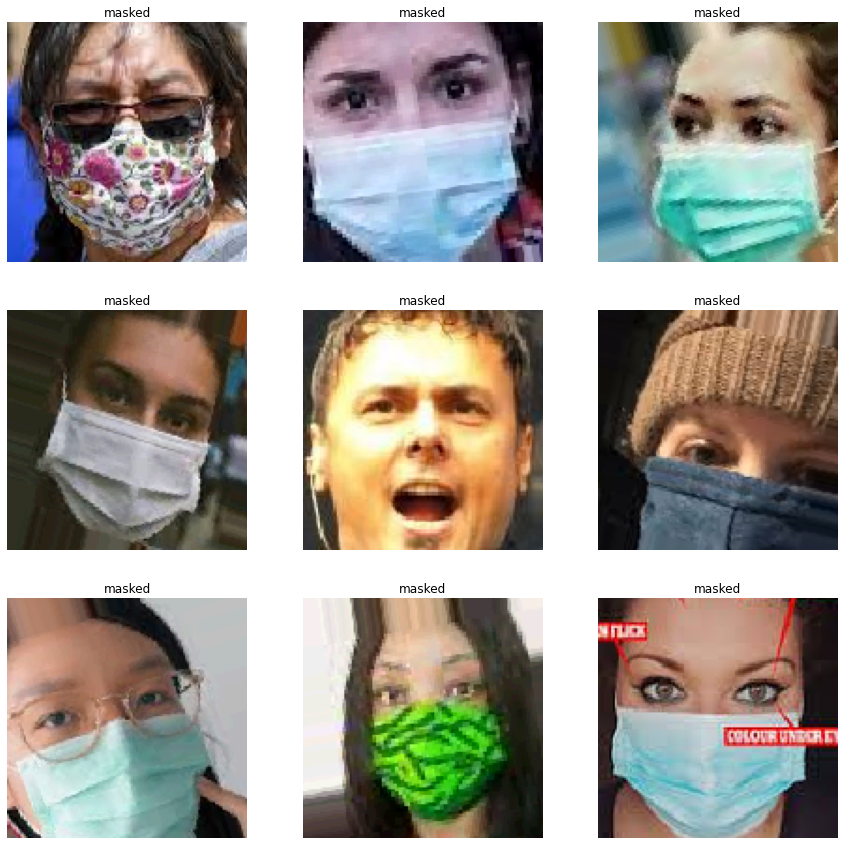

In [ ]:
## VISULIZATION
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    images, labels = next(origianal_train_data_generator)
    plt.imshow(images[i])
    plt.title(classes[int(np.argmax(labels[i]))])
    plt.axis("off")

**The loaded Examples shows that the dataset is highly generic and representative of various ethnicities and mask shapes. However some data augmentation can be performed according to the transfer learning used. Each transfer learning model will have its own preprocessing steps that will be applied to get the best performance out of it.**

# **Models**

*As one of the most popular and effect transfer learning model in use of images, VGG16 model is tried on our dataset.*

## **First Model**: VGG16

**Why it would work?**<br>
VGG16 layers are all convolutional layers with 3x3 kernels and 2x2 max pooling layers untill the 3 final dense layers. Hence, we think that VGG architecture is suitable for capturing small features variantions in the input layer and wider variations in the consecutive layers of the features space. This is practically seems useful as the deeper we go in the images in this project the less important the details are. Also, the input layer for VGG16 is RGB images which is totally important for this project to caputure the mask color variations.

The first trial is just using the pre-trained model with minimum contribution

In [ ]:
# Generators
train_data_generator, val_data_generator, test_data_generator = get_generators(tf.keras.applications.vgg16.preprocess_input)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
from keras.applications.vgg16 import VGG16

# Load model without classification head
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Mark loaded layers as not trainable
for layer in base_model.layers[2:]:
  layer.trainable = False
for layer in base_model.layers[0:2]:
  layer.trainable = True

# Add new classifier layers
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

**Let's train the model!!**

In [ ]:
# I can choose small number of epochs for initial investigation for the model perfomance
INITIAL_EPOCHS = 5

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 127s 3s/step - loss: 0.7078 - accuracy: 0.5230 - val_loss: 0.7009 - val_accuracy: 0.5500
Epoch 2/5
20/20 [==============================] - 60s 3s/step - loss: 0.6920 - accuracy: 0.5625 - val_loss: 0.6755 - val_accuracy: 0.5820
Epoch 3/5
20/20 [==============================] - 61s 3s/step - loss: 0.6675 - accuracy: 0.6065 - val_loss: 0.6627 - val_accuracy: 0.6300
Epoch 4/5
20/20 [==============================] - 61s 3s/step - loss: 0.6509 - accuracy: 0.6353 - val_loss: 0.6440 - val_accuracy: 0.6720
Epoch 5/5
20/20 [==============================] - 60s 3s/step - loss: 0.6335 - accuracy: 0.6545 - val_loss: 0.6172 - val_accuracy: 0.6940


The VGG16 model seems promising but relatively slow, hence we're going to raise the learning rate to notice its effect.

In [ ]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 64s 3s/step - loss: 0.6641 - accuracy: 0.6120 - val_loss: 0.5175 - val_accuracy: 0.7680
Epoch 2/5
20/20 [==============================] - 60s 3s/step - loss: 0.5031 - accuracy: 0.7841 - val_loss: 0.4540 - val_accuracy: 0.8200
Epoch 3/5
20/20 [==============================] - 60s 3s/step - loss: 0.4168 - accuracy: 0.8529 - val_loss: 0.3777 - val_accuracy: 0.8740
Epoch 4/5
20/20 [==============================] - 60s 3s/step - loss: 0.3656 - accuracy: 0.8855 - val_loss: 0.3464 - val_accuracy: 0.8760
Epoch 5/5
20/20 [==============================] - 60s 3s/step - loss: 0.3301 - accuracy: 0.9021 - val_loss: 0.3081 - val_accuracy: 0.9040


Yes, that's right! The model behaves better with higher learning rate. Let's try the same model with different optimizer (Adam). Also, more layers are included for robustness and somehow avoiding overfitting.

In [ ]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 64s 3s/step - loss: 6.9049 - accuracy: 0.6268 - val_loss: 0.1793 - val_accuracy: 0.9320
Epoch 2/5
20/20 [==============================] - 60s 3s/step - loss: 0.1663 - accuracy: 0.9291 - val_loss: 0.1057 - val_accuracy: 0.9600
Epoch 3/5
20/20 [==============================] - 62s 3s/step - loss: 0.0880 - accuracy: 0.9660 - val_loss: 0.0511 - val_accuracy: 0.9820
Epoch 4/5
20/20 [==============================] - 61s 3s/step - loss: 0.0521 - accuracy: 0.9824 - val_loss: 0.0458 - val_accuracy: 0.9860
Epoch 5/5
20/20 [==============================] - 61s 3s/step - loss: 0.0383 - accuracy: 0.9860 - val_loss: 0.0285 - val_accuracy: 0.9940


Adam Optimizer has already boosted the model behavior. The next step is to retrain the model as the final VGG16 model with more epochs.

In [ ]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = 10,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/10
20/20 [==============================] - 65s 3s/step - loss: 0.5032 - accuracy: 0.7874 - val_loss: 0.0635 - val_accuracy: 0.9760
Epoch 2/10
20/20 [==============================] - 61s 3s/step - loss: 0.0613 - accuracy: 0.9767 - val_loss: 0.0480 - val_accuracy: 0.9780
Epoch 3/10
20/20 [==============================] - 61s 3s/step - loss: 0.0365 - accuracy: 0.9875 - val_loss: 0.0232 - val_accuracy: 0.9920
Epoch 4/10
20/20 [==============================] - 61s 3s/step - loss: 0.0346 - accuracy: 0.9876 - val_loss: 0.0213 - val_accuracy: 0.9920
Epoch 5/10
20/20 [==============================] - 61s 3s/step - loss: 0.0248 - accuracy: 0.9924 - val_loss: 0.0305 - val_accuracy: 0.9900
Epoch 6/10
20/20 [==============================] - 61s 3s/step - loss: 0.0260 - accuracy: 0.9924 - val_loss: 0.0236 - val_accuracy: 0.9900
Epoch 7/10
20/20 [==============================] - 60s 3s/step - loss: 0.0179 - accuracy: 0.9938 - val_loss: 0.0302 - val_accuracy: 0.9940
Epoch 8/10
20/20 [==

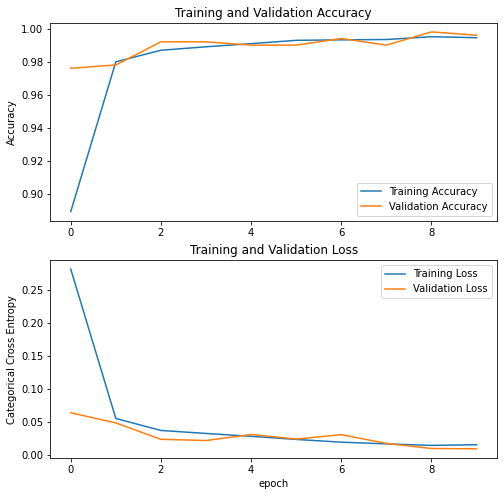

In [ ]:
plot_history(history)

### **Model Testing and Evaluation**

In [ ]:
# Evaluation on test data !
print(model.metrics_names)
model.evaluate(test_data_generator)

['loss', 'accuracy']
1/1 [==============================] - 26s 26s/step - loss: 0.4994 - accuracy: 0.9960


[0.49942144751548767, 0.9959677457809448]

**Let's show the classificaction report (Percision, recall, F1-Score)**

We're more interested in the RECALL metric. This is because the non-maksed class is the TURE (POSITIVE) class and we're concerned with avoiding classifing non-masked as masked. Hence, we're more strict againt FALSE NEGATIVE class. So, RECALL metric is the more important that PRECISION.

In [ ]:
image_samples, label_samples = next(test_data_generator)
print(image_samples.shape)
print(label_samples.shape)

(992, 128, 128, 3)
(992, 2)


In [ ]:
# As the test generator has a batch_size = 992, it's simply the whole test set
image_samples, label_samples = next(test_data_generator)
y_pred = np.argmax(model.predict(image_samples), axis=1)
print(classification_report(np.argmax(label_samples, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


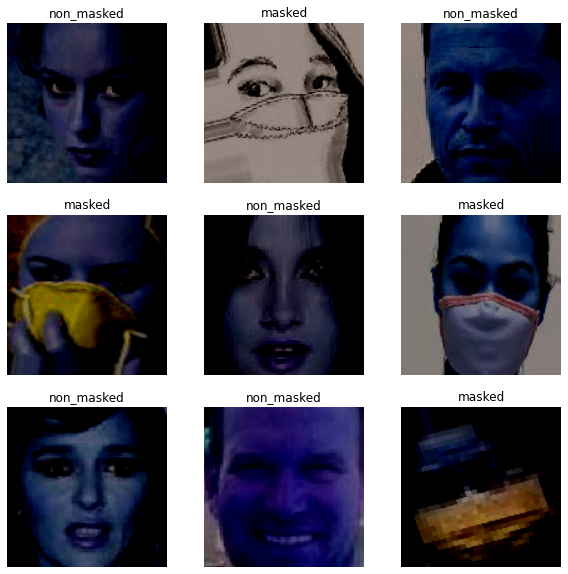

In [ ]:
## Testing
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_samples[i]/255);
    plt.title(classes[np.argmax(model.predict(np.expand_dims(image_samples[i], axis=0)))])
    plt.axis("off")

#test_img = image_samples[0]
#x = np.expand_dims(test_img, axis=0)
#plt.imshow(test_img)
#print(classes[np.argmax(model.predict(x))])

### **More Testing**

In [ ]:
!mkdir /content/random_images
!unzip -q /content/test.zip -d /content/random_images 

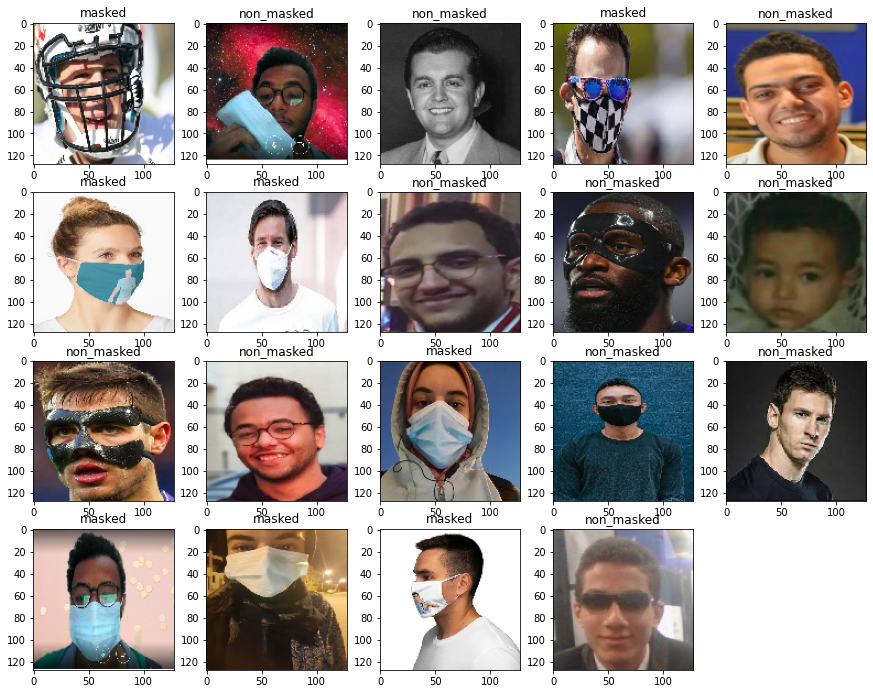

In [ ]:
from keras.applications.vgg16 import preprocess_input
plt.figure(figsize=(15, 15))
for i, img_path in enumerate(os.listdir('./random_images')):
  if img_path != '.ipynb_checkpoints':
    ax = plt.subplot(5, 5, i + 1)
    img_path = './random_images/'+img_path
    image = load_img(img_path, target_size=(128, 128))
    plt.imshow(image)
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    plt.title(classes[np.argmax(model.predict(image))])

**Last comment about the model:** <br>
1- It behaves very well on the images where only the face is focused on. In general images where the images are not cropped around the face, it makes more mistakes. <br>

**Great! We acheived the required performance with VGG16 model**

In [ ]:
# Save the model!
model.save('fmd_model_vgg16', save_format='h5')

### **Loading the model**

In [ ]:
vgg16_model = keras.models.load_model('fmd_model_vgg16')

In [ ]:
vgg16_model.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0  

## **Second Model**: EffecientNets

### EffecientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
# Load model without classification head
base_model = EfficientNetB0(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

# Add new classifier layers
x = layers.Flatten()(base_model.layers[-1].output)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(2, activation='sigmoid')(x)

# Define new model
model = tf.keras.Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 128, 128, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
normalization_8 (Normalization) (None, 128, 128, 3)  7           rescaling_8[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization_8[0][0]            
____________________________________________________________________________________________

**Let's train the model!!**

In [ ]:
# I can choose small number of epochs for initial investigation for the model perfomance
INITIAL_EPOCHS = 10
es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)
history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE,
                    callbacks = es)


Epoch 1/10
50/50 [==============================] - 77s 1s/step - loss: 0.0966 - accuracy: 0.9641 - val_loss: 0.0295 - val_accuracy: 0.9900
Epoch 2/10
50/50 [==============================] - 67s 1s/step - loss: 0.0279 - accuracy: 0.9903 - val_loss: 0.0284 - val_accuracy: 0.9950
Epoch 3/10
50/50 [==============================] - 67s 1s/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 0.0096 - val_accuracy: 0.9975
Epoch 4/10
50/50 [==============================] - 67s 1s/step - loss: 0.0154 - accuracy: 0.9944 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 67s 1s/step - loss: 0.0149 - accuracy: 0.9948 - val_loss: 0.0049 - val_accuracy: 0.9987
Epoch 6/10
50/50 [==============================] - 66s 1s/step - loss: 0.0121 - accuracy: 0.9952 - val_loss: 0.0155 - val_accuracy: 0.9950
Epoch 7/10
50/50 [==============================] - 66s 1s/step - loss: 0.0113 - accuracy: 0.9959 - val_loss: 0.0133 - val_accuracy: 0.9962
Epoch 8/10
50/50 [==

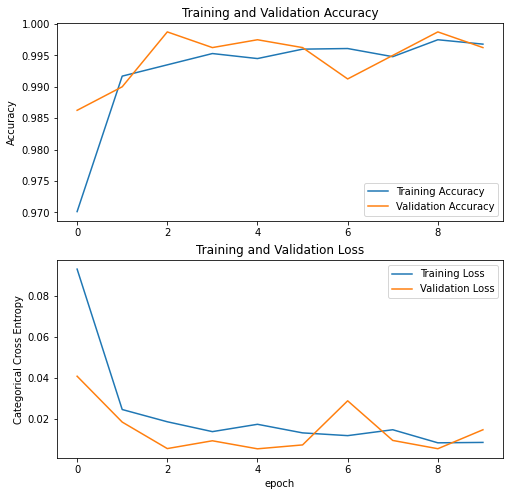

In [ ]:
plot_history(history)

In [ ]:
!pip install -q pyyaml h5py

In [ ]:
model.save('EffecientNetB0_001_3_final_Adam.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Loading model and testing

In [ ]:
model = keras.models.load_model('/content/EffecientNetB0_001_3_final_Adam.h5')

In [ ]:
# Evaluation on test data !
print(model.metrics_names)
model.evaluate(test_data_generator)

['loss', 'accuracy']
1/1 [==============================] - 7s 7s/step - loss: 0.0108 - accuracy: 0.9960


[0.010791052132844925, 0.9959677457809448]

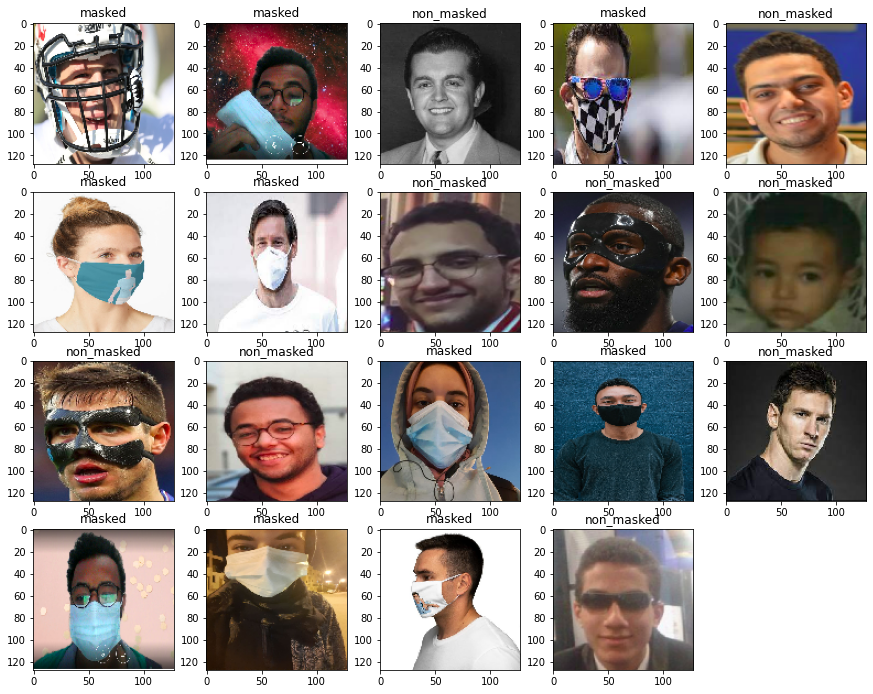

In [ ]:
from keras.applications.vgg16 import preprocess_input
plt.figure(figsize=(15, 15))
for i, img_path in enumerate(os.listdir('./random_images')):
  if img_path != '.ipynb_checkpoints':
    ax = plt.subplot(5, 5, i + 1)
    img_path = './random_images/'+img_path
    image = load_img(img_path, target_size=(128, 128))
    plt.imshow(image)
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    plt.title(classes[np.argmax(model.predict(image))])

In [ ]:
# We're testing images
image_samples, label_samples = next(test_data_generator)
y_pred = np.argmax(model.predict(image_samples), axis=1)
print(classification_report(np.argmax(label_samples, axis=1), y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



### B1

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
# Load model without classification head
base_model = EfficientNetB1(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

# Add new classifier layers
x = layers.Flatten()(base_model.layers[-1].output)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(2, activation='sigmoid')(x)

# Define new model
model_b1 = tf.keras.Model(inputs = base_model.inputs, outputs = output)

# Print summary
model_b1.summary()

# Compile
base_learning_rate = 0.001
model_b1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling_10 (Rescaling)        (None, 128, 128, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
normalization_10 (Normalization (None, 128, 128, 3)  7           rescaling_10[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization_10[0][0]           
___________________________________________________________________________________________

**Let's train the model!!**

In [ ]:
# I can choose small number of epochs for initial investigation for the model perfomance
INITIAL_EPOCHS = 10

history = model_b1.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/10
50/50 [==============================] - 77s 1s/step - loss: 0.0929 - accuracy: 0.9701 - val_loss: 0.0408 - val_accuracy: 0.9862
Epoch 2/10
50/50 [==============================] - 65s 1s/step - loss: 0.0247 - accuracy: 0.9917 - val_loss: 0.0186 - val_accuracy: 0.9900
Epoch 3/10
50/50 [==============================] - 65s 1s/step - loss: 0.0187 - accuracy: 0.9935 - val_loss: 0.0057 - val_accuracy: 0.9987
Epoch 4/10
50/50 [==============================] - 65s 1s/step - loss: 0.0139 - accuracy: 0.9953 - val_loss: 0.0095 - val_accuracy: 0.9962
Epoch 5/10
50/50 [==============================] - 65s 1s/step - loss: 0.0175 - accuracy: 0.9945 - val_loss: 0.0056 - val_accuracy: 0.9975
Epoch 6/10
50/50 [==============================] - 65s 1s/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.0075 - val_accuracy: 0.9962
Epoch 7/10
50/50 [==============================] - 65s 1s/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0289 - val_accuracy: 0.9912
Epoch 8/10
50/50 [==

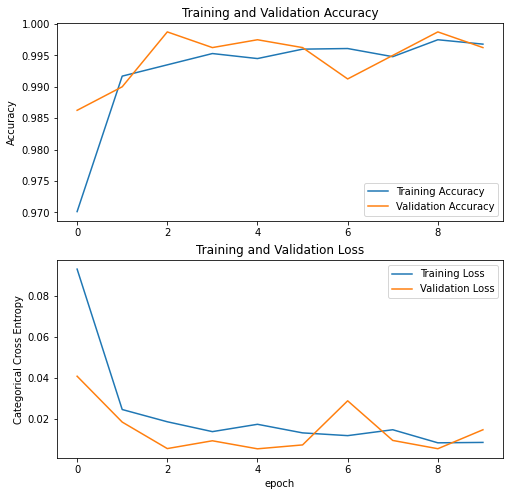

In [ ]:
plot_history(history)

In [ ]:
model_b1.save('EffecientNetB1_001_Adam.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Evaluation on test data !
print(model_b1.metrics_names)
model_b1.evaluate(test_data_generator, steps=2)

['loss', 'accuracy']
2/2 [==============================] - 3s 1s/step - loss: 0.0308 - accuracy: 0.9875


[0.030786721035838127, 0.987500011920929]

##**Third model**: MobileNetV2

Mobile net is a very light weight model. With its minimal number of parameters and effecient structure it can perform like bigger models that include numerous of unneeded parametrs. 

**The first trial is just using the pre-trained model with minimum contribution**

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

# Load model without classification head
base_model = MobileNetV2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# I can choose small number of epochs for initial investigation for the model perfomance
INITIAL_EPOCHS = 5

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 63s 3s/step - loss: 0.8445 - accuracy: 0.5042 - val_loss: 0.7214 - val_accuracy: 0.5260
Epoch 2/5
20/20 [==============================] - 51s 3s/step - loss: 0.7070 - accuracy: 0.5162 - val_loss: 0.6859 - val_accuracy: 0.5480
Epoch 3/5
20/20 [==============================] - 51s 3s/step - loss: 0.6817 - accuracy: 0.5601 - val_loss: 0.6942 - val_accuracy: 0.5080
Epoch 4/5
20/20 [==============================] - 50s 3s/step - loss: 0.6828 - accuracy: 0.5420 - val_loss: 0.6795 - val_accuracy: 0.5880
Epoch 5/5
20/20 [==============================] - 51s 3s/step - loss: 0.6762 - accuracy: 0.5641 - val_loss: 0.6737 - val_accuracy: 0.5620


**Adding and Unfreezing Layres** 

In [ ]:
# Load model without classification head
base_model = MobileNetV2(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Mark loaded layers as not trainable
for layer in base_model.layers[2:]:
  layer.trainable = False
for layer in base_model.layers[0:2]:
  layer.trainable = True
  
#Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 118s 3s/step - loss: 0.8680 - accuracy: 0.4936 - val_loss: 0.6856 - val_accuracy: 0.5540
Epoch 2/5
20/20 [==============================] - 53s 3s/step - loss: 0.6857 - accuracy: 0.5415 - val_loss: 0.6930 - val_accuracy: 0.5340
Epoch 3/5
20/20 [==============================] - 54s 3s/step - loss: 0.6814 - accuracy: 0.5438 - val_loss: 0.6692 - val_accuracy: 0.6060
Epoch 4/5
20/20 [==============================] - 53s 3s/step - loss: 0.6705 - accuracy: 0.5879 - val_loss: 0.6678 - val_accuracy: 0.5640
Epoch 5/5
20/20 [==============================] - 54s 3s/step - loss: 0.6639 - accuracy: 0.5907 - val_loss: 0.6741 - val_accuracy: 0.5380


**The learning process is too slow. So, Let's test higher learning rates**

In [ ]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 65s 3s/step - loss: 2.6932 - accuracy: 0.5013 - val_loss: 0.6754 - val_accuracy: 0.5840
Epoch 2/5
20/20 [==============================] - 54s 3s/step - loss: 0.6913 - accuracy: 0.5397 - val_loss: 0.6663 - val_accuracy: 0.5880
Epoch 3/5
20/20 [==============================] - 54s 3s/step - loss: 0.6617 - accuracy: 0.5969 - val_loss: 0.6695 - val_accuracy: 0.5600
Epoch 4/5
20/20 [==============================] - 54s 3s/step - loss: 0.6477 - accuracy: 0.5980 - val_loss: 0.6707 - val_accuracy: 0.5340
Epoch 5/5
20/20 [==============================] - 54s 3s/step - loss: 0.6251 - accuracy: 0.6172 - val_loss: 0.6010 - val_accuracy: 0.6780


**The learning process is too slow. So, Let's test higher learning rates**

In [ ]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 65s 3s/step - loss: 2.6932 - accuracy: 0.5013 - val_loss: 0.6754 - val_accuracy: 0.5840
Epoch 2/5
20/20 [==============================] - 54s 3s/step - loss: 0.6913 - accuracy: 0.5397 - val_loss: 0.6663 - val_accuracy: 0.5880
Epoch 3/5
20/20 [==============================] - 54s 3s/step - loss: 0.6617 - accuracy: 0.5969 - val_loss: 0.6695 - val_accuracy: 0.5600
Epoch 4/5
20/20 [==============================] - 54s 3s/step - loss: 0.6477 - accuracy: 0.5980 - val_loss: 0.6707 - val_accuracy: 0.5340
Epoch 5/5
20/20 [==============================] - 54s 3s/step - loss: 0.6251 - accuracy: 0.6172 - val_loss: 0.6010 - val_accuracy: 0.6780


In [ ]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = 20,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/20
20/20 [==============================] - 65s 3s/step - loss: 31.1535 - accuracy: 0.5189 - val_loss: 1.1992 - val_accuracy: 0.7020
Epoch 2/20
20/20 [==============================] - 53s 3s/step - loss: 1.3506 - accuracy: 0.6582 - val_loss: 1.1904 - val_accuracy: 0.6020
Epoch 3/20
20/20 [==============================] - 53s 3s/step - loss: 0.6264 - accuracy: 0.7499 - val_loss: 0.3531 - val_accuracy: 0.8520
Epoch 4/20
20/20 [==============================] - 53s 3s/step - loss: 0.3778 - accuracy: 0.8218 - val_loss: 0.4726 - val_accuracy: 0.7660
Epoch 5/20
20/20 [==============================] - 53s 3s/step - loss: 0.4280 - accuracy: 0.8064 - val_loss: 0.3478 - val_accuracy: 0.8340
Epoch 6/20
20/20 [==============================] - 53s 3s/step - loss: 0.3775 - accuracy: 0.8278 - val_loss: 0.3933 - val_accuracy: 0.8200
Epoch 7/20
20/20 [==============================] - 53s 3s/step - loss: 0.4028 - accuracy: 0.8261 - val_loss: 0.2763 - val_accuracy: 0.8700
Epoch 8/20
20/20 [=

**Trying to increase the Complexity of the model** 

In [ ]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = 20,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/20
20/20 [==============================] - 65s 3s/step - loss: 1.4801 - accuracy: 0.5182 - val_loss: 0.5746 - val_accuracy: 0.7120
Epoch 2/20
20/20 [==============================] - 53s 3s/step - loss: 0.5657 - accuracy: 0.7010 - val_loss: 0.4849 - val_accuracy: 0.7720
Epoch 3/20
20/20 [==============================] - 53s 3s/step - loss: 0.4174 - accuracy: 0.8096 - val_loss: 0.3297 - val_accuracy: 0.8760
Epoch 4/20
20/20 [==============================] - 53s 3s/step - loss: 0.3330 - accuracy: 0.8569 - val_loss: 0.3153 - val_accuracy: 0.8620
Epoch 5/20
20/20 [==============================] - 53s 3s/step - loss: 0.2858 - accuracy: 0.8766 - val_loss: 0.2940 - val_accuracy: 0.8700
Epoch 6/20
20/20 [==============================] - 53s 3s/step - loss: 0.2681 - accuracy: 0.8880 - val_loss: 0.3055 - val_accuracy: 0.8680
Epoch 7/20
20/20 [==============================] - 53s 3s/step - loss: 0.2560 - accuracy: 0.8970 - val_loss: 0.2811 - val_accuracy: 0.8880
Epoch 8/20
20/20 [==

**Other two parameters were tested (the optimizet and the learning rate schedulers). However after testing RMSprop, Adam was performing better. In addition, the model's performance during the training was not stable while using ExponentialDecay learning rate schelulers. So, these parameters are kept as the previous shown models**

**The last model seems to perform well on the training and validation data**

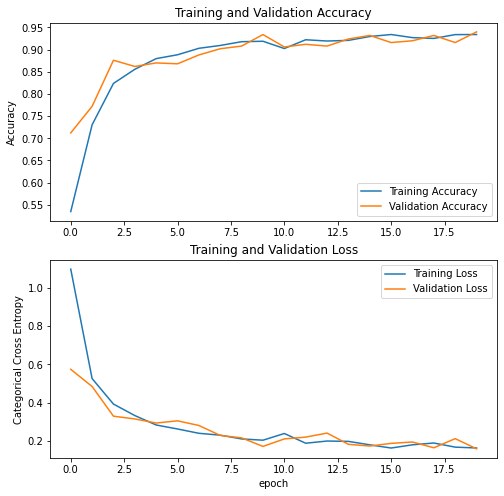

In [ ]:
plot_history(history)

In [ ]:
# As the test generator has a batch_size = 992, it's simply the whole test set
image_samples, label_samples = next(test_data_generator)
y_pred = np.argmax(model.predict(image_samples), axis=1)
print(classification_report(np.argmax(label_samples, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.49      1.00      0.65       483
           1       0.00      0.00      0.00       509

    accuracy                           0.49       992
   macro avg       0.24      0.50      0.33       992
weighted avg       0.24      0.49      0.32       992



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluation on test data !
print(model.metrics_names)
model.evaluate(test_data_generator)

['loss', 'accuracy']
1/1 [==============================] - 2s 2s/step - loss: 11.1646 - accuracy: 0.4869


[11.164570808410645, 0.4868951737880707]

The model is not performing well on the test data. So when regarding a real life application, the other two transfer learning models are better. 